In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from muniverse.algorithms.decomposition_methods import upper_bound, basic_cBSS
from muniverse.algorithms.decomposition_routines import *
import matplotlib.pyplot as plt
from muniverse.evaluation.evaluate import *
from pathlib import Path
import time

In [2]:
datapath = str(Path.home()) + '/Documents/muniverse-data/'

muap_data = loadmat(datapath + 'muap.mat', struct_as_record=False, squeeze_me=True)
emg_data  = loadmat(datapath + 'emg_data.mat', struct_as_record=False, squeeze_me=True)
gt_spikes  = loadmat(datapath + 'spikes.mat', struct_as_record=False, squeeze_me=True)

fsamp = 2048
MUAPs = muap_data['muaps'] 
SIG = emg_data['data']

sdict = {}
for i in np.arange(148): 
    sdict[i] = gt_spikes['spike_times'][i]
gt_spikes = spike_dict_to_long_df(sdict, fsamp=10000)
gt_spikes = gt_spikes.rename(columns={'source_id': 'unit_id'})
gt_spikes['spike_time'] = gt_spikes['spike_time']
gt_spikes['timestamp'] = (gt_spikes['spike_time']*fsamp).astype(int)


In [3]:
UB = upper_bound(sil_th = 0, ext_fact = 12)

start = time.time()
sources2, spikes2, sil2, mu_filters2 = UB.decompose(SIG, MUAPs, fsamp)
end = time.time()
print(f"Runtime: {end - start:.6f} seconds")

ub_spikes = spike_dict_to_long_df(spikes2, fsamp=fsamp)
ub_spikes = ub_spikes.rename(columns={'source_id': 'unit_id'})
ub_spikes['spike_time'] = ub_spikes['spike_time']
ub_spikes['timestamp'] = (ub_spikes['spike_time']*fsamp).astype(int)

Runtime: 9.475481 seconds


In [4]:
cBSS = basic_cBSS(sil_th = 0.85, ext_fact = 12)

start = time.time()
sources, spikes, sil, mu_filters = cBSS.decompose(SIG, fsamp)
end = time.time()
print(f"Runtime: {end - start:.6f} seconds")

cbss_spikes = spike_dict_to_long_df(spikes, fsamp=fsamp)
cbss_spikes = cbss_spikes.rename(columns={'source_id': 'unit_id'})
cbss_spikes['spike_time'] = cbss_spikes['spike_time'] 
cbss_spikes['timestamp'] = (cbss_spikes['spike_time']*fsamp).astype(int)

Runtime: 655.978397 seconds


     unit_id  unit_id_ref  delay_seconds   TP   FN   FP
0          0            0      -0.002930  357  185  146
1          1            1      -0.001953  321  212  151
2          2            2      -0.000977  327  211  201
3          3            3      -0.002441  278  261  264
4          4            4      -0.001953  106  429  416
..       ...          ...            ...  ...  ...  ...
143      143          143      -0.095215    1    5  563
144      144          144      -0.002930    2    0  401
145      145          145      -0.077148    1    2  447
146      146          146       0.000000    3    0  425
147      147          147      -0.093262    1    1  506

[148 rows x 6 columns]
14


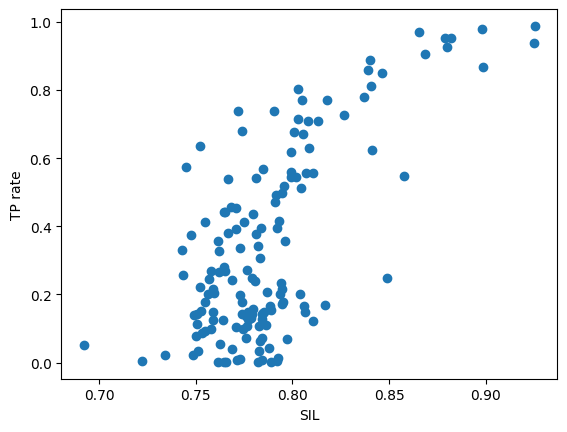

In [5]:
#df1 = evaluate_spike_matches(cbss_spikes, gt_spikes, t_start = 0, t_end = 40)
df2 = evaluate_spike_matches(ub_spikes, gt_spikes, t_start = 0, t_end = 40, pre_matched=True, fsamp=2048)
print(df2)
tpr = df2['TP'] / (df2['TP'] + df2['FP'])
print(np.sum(tpr > 0.8))

#print(df1)
plt.figure(1)
plt.plot(sil2, tpr,'o')
plt.xlabel('SIL')
plt.ylabel('TP rate')
plt.show()

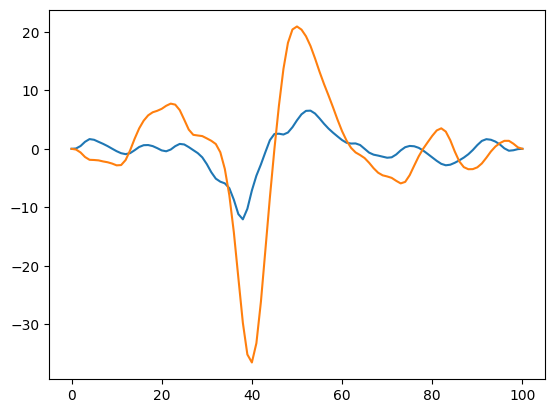

In [6]:
plt.figure(2)
plt.plot(MUAPs[0,32,:])
plt.plot(MUAPs[-1,32,:])
#print(np.mean(MUAPs[-1,32,:]))

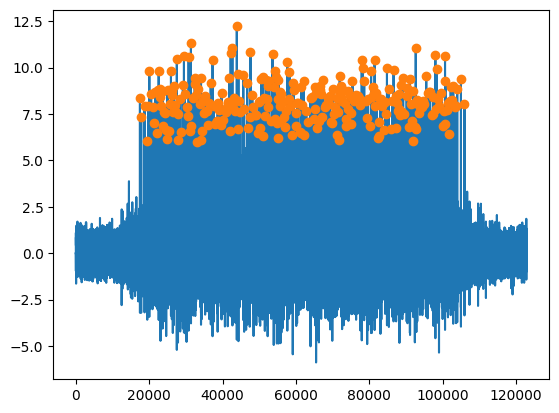

In [8]:
idx = 0
plt.figure(11)
plt.plot(sources[idx,:])
plt.plot(spikes[idx],sources[idx,spikes[idx]],'o')
plt.show()